<a href="https://colab.research.google.com/github/jjlopezre/Analitica-de-datos/blob/Taller2/Copia_de_pruebapeopleclasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 
    
import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()

    
#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Carpeta results ya existe


# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


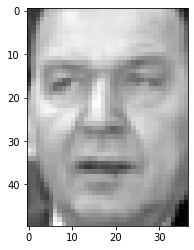

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123) 
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.235294,0.308497,0.386928,0.443137,0.504575,0.529412,0.550327,0.550327,0.558170,0.566013,0.577778,0.603922,0.626144,0.633987,0.644444,0.657516,0.657516,0.660131,0.647059,0.632680,0.623529,0.611765,0.611765,0.622222,0.616993,0.618301,0.603922,0.534640,0.423529,0.405229,0.406536,0.325490,0.184314,0.145098,0.145098,0.158170,0.155556,0.347712,0.407843,0.464052,...,0.168627,0.094118,0.109804,0.128105,0.109804,0.202614,0.678431,0.878431,0.853595,0.722876,0.507190,0.427451,0.415686,0.392157,0.368627,0.342484,0.321569,0.321569,0.286275,0.141176,0.103268,0.103268,0.087582,0.092810,0.096732,0.099346,0.107190,0.113725,0.122876,0.135948,0.160784,0.377778,0.610458,0.830065,0.955556,0.975163,0.789542,0.247059,0.109804,0.115033
1035,0.403922,0.443137,0.496732,0.609150,0.711111,0.749020,0.741176,0.721569,0.716340,0.692810,0.667974,0.644444,0.649673,0.656209,0.647059,0.645752,0.657516,0.666667,0.653595,0.641830,0.666667,0.678431,0.674510,0.670588,0.673203,0.686275,0.708497,0.726797,0.739869,0.755556,0.742484,0.729412,0.681046,0.648366,0.433987,0.437909,0.520261,0.396078,0.437909,0.533333,...,0.099346,0.111111,0.118954,0.173856,0.145098,0.098039,0.200000,0.596078,0.861438,0.520261,0.422222,0.444444,0.413072,0.400000,0.448366,0.419608,0.338562,0.322876,0.337255,0.335948,0.337255,0.339869,0.333333,0.313726,0.328105,0.309804,0.274510,0.167320,0.094118,0.052288,0.065359,0.084967,0.087582,0.100654,0.083660,0.086275,0.095425,0.115033,0.111111,0.111111
176,0.237908,0.307190,0.311111,0.332026,0.383007,0.427451,0.447059,0.453595,0.470588,0.475817,0.491503,0.491503,0.500654,0.516340,0.529412,0.526797,0.543791,0.564706,0.568627,0.573856,0.580392,0.586928,0.600000,0.600000,0.598693,0.585621,0.573856,0.562091,0.533333,0.516340,0.494118,0.462745,0.436601,0.388235,0.330719,0.209150,0.256209,0.294118,0.347712,0.350327,...,0.141176,0.152941,0.145098,0.158170,0.213072,0.623529,0.950327,0.985621,0.979085,0.929412,0.769935,0.584314,0.501961,0.454902,0.424837,0.432680,0.448366,0.475817,0.498039,0.511111,0.500654,0.498039,0.537255,0.533333,0.503268,0.492810,0.437909,0.326797,0.186928,0.124183,0.116340,0.117647,0.121569,0.120261,0.122876,0.118954,0.130719,0.142484,0.151634,0.137255
620,0.081046,0.166013,0.379085,0.562091,0.632680,0.640523,0.639216,0.644444,0.656209,0.666667,0.681046,0.690196,0.716340,0.730719,0.735948,0.738562,0.737255,0.758170,0.750327,0.733333,0.730719,0.737255,0.718954,0.692810,0.688889,0.688889,0.684967,0.647059,0.618301,0.579085,0.516340,0.462745,0.428758,0.335948,0.155556,0.067974,0.074510,0.137255,0.261438,0.473203,...,0.079739,0.115033,0.156863,0.884967,0.864052,0.865359,0.877124,0.860131,0.836601,0.826144,0.836601,0.850980,0.862745,0.866667,0.866667,0.830065,0.767320,0.631373,0.501961,0.470588,0.460131,0.467974,0.481046,0.467974,0.420915,0.427451,0.475817,0.509804,0.466667,0.422222,0.347712,0.341176,0.190850,0.050980,0.048366,0.064052,0.079739,0.100654,0.135948,0.166013
689,0.590850,0.607843,0.503268,0.464052,0.558170,0.735948,0.747712,0.688889,0.684967,0.716340,0.717647,0.717647,0.720261,0.722876,0.730719,0.728105,0.728105,0.730719,0.717647,0.709804,0.708497,0.704575,0.704575,0.688889,0.675817,0.678431,0.669281,0.654902,0.636601,0.648366,0.637909,0.644444,0.637909,0.607843,0.573856,0.499346,0.467974,0.728105,0.600000,0.473203,...,0.747712,0.883660,0.908497,0.166013,0.162091,0.155556,0.132026,0.100654,0.142484,0.201307,0.201307,0.206536,0.213072,0.171242,0.159477,0.218301,0.390850,0.483660,0.481046,0.488889,0.500654,0.517647,0.520261,0.492810,0.471895,0.450980,0.433987,0.424837,0.423529,0.411765,0.401307,0.389542,0.398693,0.415686,0.462745,0.579085,0.772549,0.882353,0.909804,0.916340


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]
       
parameters = [{              
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros 
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()
models[i].cv_results_['mean_test_score'][i]


0.4306445672191529

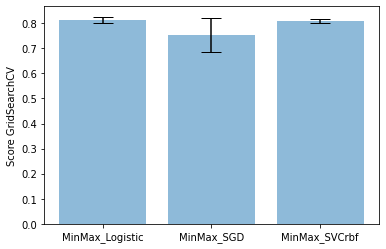

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.814 0.752 0.808]
 [0.012 0.068 0.008]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/).

Evaluando modelo MinMax_Logistic (1/3)


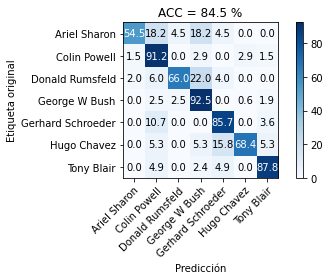

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.55      0.67        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.87      0.66      0.75        50
    George W Bush       0.89      0.92      0.90       159
Gerhard Schroeder       0.75      0.86      0.80        28
      Hugo Chavez       0.81      0.68      0.74        19
       Tony Blair       0.86      0.88      0.87        41

         accuracy                           0.84       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.84      0.84       387

Evaluando modelo MinMax_SGD (2/3)


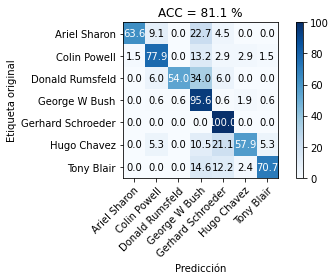

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.88      0.78      0.83        68
  Donald Rumsfeld       0.96      0.54      0.69        50
    George W Bush       0.80      0.96      0.87       159
Gerhard Schroeder       0.64      1.00      0.78        28
      Hugo Chavez       0.65      0.58      0.61        19
       Tony Blair       0.91      0.71      0.79        41

         accuracy                           0.81       387
        macro avg       0.82      0.74      0.76       387
     weighted avg       0.83      0.81      0.81       387

Evaluando modelo MinMax_SVCrbf (3/3)


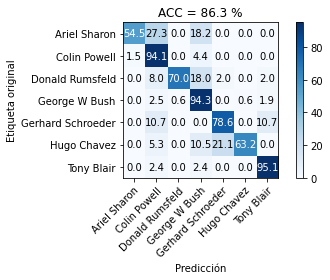

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.55      0.69        22
     Colin Powell       0.77      0.94      0.85        68
  Donald Rumsfeld       0.97      0.70      0.81        50
    George W Bush       0.89      0.94      0.91       159
Gerhard Schroeder       0.81      0.79      0.80        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.85      0.95      0.90        41

         accuracy                           0.86       387
        macro avg       0.88      0.79      0.82       387
     weighted avg       0.87      0.86      0.86       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo. 

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


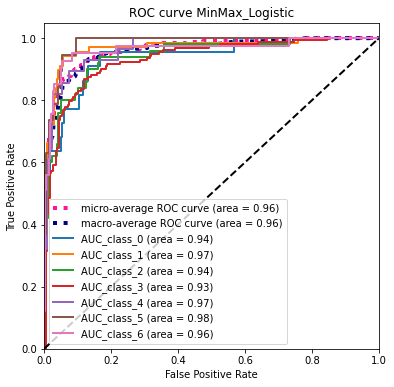

Evaluando modelo MinMax_SGD (2/3)


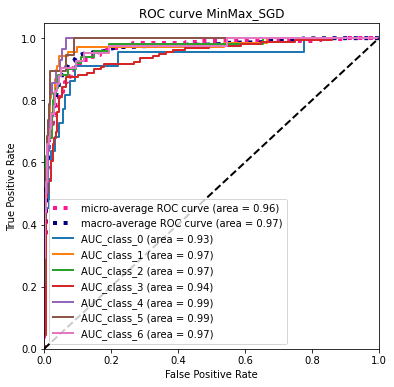

Evaluando modelo MinMax_SVCrbf (3/3)


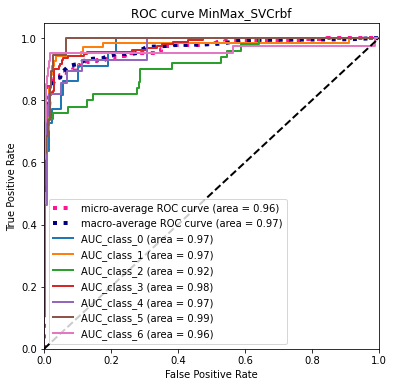

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest) 
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html):
Esta técnica de clasificación supervisada basada en el Teorema de Bayes asume que hay independencia entre los atributos, esto es, la aparición de una característica en una clase no está relacionada con la presencia de cualquier otra característica.
Incluso, si alguna característica depende de otra, todas contribuyen de manera independiente a la probabilidad a posteriori. Se llama ingenuo precisamente por asumir la independencia en los atributos, algo que en la realidad no se suele dar.
Este clasificador se ha usado en escenarios como:
Análisis de sentimientos: análisis de los tweets, revisiones y comentarios. 
Clasicación de texto: conocido de manera exitosa en la clasificación de texto,
determinación de si un texto pertenece a una o varias categoría. 
Detección de spam: ejemplo de clasicación de texto en correo electrónico.
Debido a las suposiciones que hace el clasicador bayesiano ingenuo sobre los datos, generalmente no funciona para modelos complejos.
Ventajas:
Rápidos en entrenamiento y predicción.
Proporción de predicción probabilística directa.
Fáciles de interpretar.
Pocos parámetros a optimizar.
Dicho esto, este clasificador es una buena opción de modelo de clasicación inicial.
Si se obtienen buenos resultados, se tiene un clasificador rápido, en caso contrario se tiene una base con que explorar modelos más robustos.
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html): Este estimador implementa modelos lineales regularizados con aprendizaje de descenso de gradiente estocástico (SGD): el gradiente de la pérdida se estima cada muestra a la vez y el modelo se actualiza a lo largo del camino con un programa de fuerza decreciente (también conocido como tasa de aprendizaje). SGD permite el aprendizaje de minilotes (en línea/fuera del núcleo) a través del partial_fitmétodo. Para obtener los mejores resultados con el programa de tasa de aprendizaje predeterminado, los datos deben tener una media cero y una varianza unitaria.
Esta implementación funciona con datos representados como matrices densas o dispersas de valores de punto flotante para las entidades. El modelo al que se ajusta se puede controlar con el parámetro de pérdida; por defecto, se ajusta a una máquina de vectores de soporte lineal (SVM).
El regularizador es una penalización añadida a la función de pérdida que reduce los parámetros del modelo hacia el vector cero usando la norma euclidiana cuadrática L2 o la norma absoluta L1 o una combinación de ambas (Elastic Net). Si la actualización de parámetros cruza el valor 0.0 debido al regularizador, la actualización se trunca a 0.0 para permitir el aprendizaje de modelos dispersos y lograr la selección de características en línea.

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): La regresión logística es un algoritmo de clasificación de aprendizaje supervisado que se utiliza para predecir la probabilidad de una variable objetivo. La naturaleza de la variable objetivo o dependiente es dicotómica, lo que significa que solo habría dos clases posibles.
En palabras simples, la variable dependiente es de naturaleza binaria y tiene datos codificados como 1 (significa éxito/sí) o 0 (significa falla/no).Matemáticamente, un modelo de regresión logística predice P(Y=1) como una función de X. Es uno de los algoritmos de ML más simples que se pueden usar para varios problemas de clasificación, como detección de spam, predicción de diabetes, detección de cáncer, etc.


- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html):es una generalización del discriminante lineal de Fisher, un método utilizado en estadística y otros campos para encontrar una combinación lineal de características que caracteriza o separa dos o más clases de objetos o eventos. La combinación resultante puede usarse como un clasificador lineal o, más comúnmente, para la reducción de la dimensionalidad antes de una clasificación posterior.
Un clasificador con un límite de decisión lineal, generado ajustando densidades condicionales de clase a los datos y usando la regla de Bayes.
El modelo ajusta una densidad gaussiana a cada clase, asumiendo que todas las clases comparten la misma matriz de covarianza.
El modelo ajustado también se puede usar para reducir la dimensionalidad de la entrada proyectándola en las direcciones más discriminatorias, usando el transformmétodo.


- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): es un algoritmo basado en instancia de tipo supervisado de Machine Learning. Puede usarse para clasificar nuevas muestras (valores discretos) o para predecir (regresión, valores continuos). Al ser un método sencillo, es ideal para introducirse en el mundo del  Aprendizaje Automático. Sirve esencialmente para clasificar valores buscando los puntos de datos “más similares” (por cercanía) aprendidos en la etapa de entrenamiento y haciendo conjeturas de nuevos puntos basado en esa clasificación.
-¿Cómo funciona kNN?
Calcular la distancia entre el item a clasificar y el resto de items del dataset de entrenamiento.
Seleccionar los “k” elementos más cercanos (con menor distancia, según la función que se use)
Realizar una “votación de mayoría” entre los k puntos: los de una clase/etiqueta que <<dominen>> decidirán su clasificación final.
Teniendo en cuenta el punto 3, veremos que para decidir la clase de un punto es muy importante el valor de k, pues este terminará casi por definir a qué grupo pertenecerán los puntos, sobre todo en las “fronteras” entre grupos. Por ejemplo -y a priori- yo elegiría valores impares de k para desempatar (si las features que utilizamos son pares). No será lo mismo tomar para decidir 3 valores que 13. Esto no quiere decir que necesariamente tomar más puntos implique mejorar la precisión. Lo que es seguro es que cuantos más “puntos k”, más tardará nuestro algoritmo en procesar y darnos respuesta 
Las formas más populares de “medir la cercanía” entre puntos son la distancia Euclidiana (la “de siempre”) o la Cosine Similarity (mide el ángulo de  los vectores, cuanto menores, serán similares). Recordemos que este algoritmo -y prácticamente todos en ML- funcionan mejor con varias características de las que tomemos datos (las columnas de nuestro dataset). Lo que entendemos como “distancia” en la vida real, quedará abstracto a muchas dimensiones que no podemos “visualizar” fácilmente (como por ejemplo en un mapa).



- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html): Similar a SVC con el parámetro kernel='linear', pero implementado en términos de liblinear en lugar de libsvm, por lo que tiene más flexibilidad en la elección de penalizaciones y funciones de pérdida y debería escalar mejor a un gran número de muestras.
Esta clase admite entradas densas y dispersas y el soporte multiclase se maneja de acuerdo con un esquema de uno contra el resto.
El objetivo de un SVC lineal (clasificador de vectores de soporte) es ajustarse a los datos que proporciona, devolviendo un hiperplano de "mejor ajuste" que divide o categoriza sus datos. A partir de ahí, después de obtener el hiperplano, puede enviar algunas características a su clasificador para ver cuál es la clase "predicha". Esto hace que este algoritmo específico sea bastante adecuado para nuestros usos, aunque puede usarlo para muchas situaciones
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): El clasificador de vectores de soporte tiene como objetivo crear una línea de decisión que clasificaría una nueva observación como un triángulo violeta debajo de esta línea y una cruz naranja sobre la línea.
SVC tiene como objetivo trazar una línea recta entre dos clases de modo que la brecha entre las dos clases sea lo más amplia posible.
Parametros ajustables: C es el parámetro de penalización por el error: un valor bajo de C proporciona un límite de decisión más uniforme y generalizado (sesgo alto) y, a medida que aumenta C, aumenta la varianza en su clasificador.
Gamma es inversamente proporcional al rango del efecto de una sola muestra de entrenamiento: si es baja, la muestra tendrá efectos de largo alcance, pero si es alta, la muestra solo tendrá efectos localizados.
El estado aleatorio se establecerá para que obtengamos resultados repetibles.
Es importante ajustar estos parámetros para su modelo. Usaremos un valor de C de 1 y gamma de 0.001 y el núcleo de la función de base radial (rbf).

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): Un bosque aleatorio es un metaestimador que ajusta una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. El tamaño de la submuestra se controla con el max_samplesparámetro if bootstrap=True(predeterminado); de lo contrario, se usa todo el conjunto de datos para construir cada árbol. En los bosques aleatorios, cada árbol del conjunto se construye a partir de una muestra extraída con reemplazo (es decir, una muestra de arranque) del conjunto de entrenamiento.
Además, al dividir cada nodo durante la construcción de un árbol, la mejor división se encuentra entre todas las entidades de entrada o un subconjunto aleatorio de tamaño max_features.
El propósito de estas dos fuentes de aleatoriedad es disminuir la varianza del estimador forestal. De hecho, los árboles de decisión individuales suelen exhibir una gran variación y tienden a sobreajustarse. La aleatoriedad inyectada en los bosques produce árboles de decisión con errores de predicción algo desacoplados. Al tomar un promedio de esas predicciones, algunos errores pueden cancelarse. Los bosques aleatorios logran una varianza reducida al combinar árboles diversos, a veces a costa de un ligero aumento en el sesgo. En la práctica, la reducción de la varianza suele ser significativa, por lo que genera un mejor modelo general.

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1. 


In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())],#Pipeline3
       [('nor', MinMaxScaler()),
        ('cla', RandomForestClassifier())], #Pipeline4
       [('nor', MinMaxScaler()),
        ('cla', GaussianNB())], #Pipeline5
       [('nor', MinMaxScaler()),
        ('cla', LinearDiscriminantAnalysis())], #Pipeline6
       [('nor', MinMaxScaler()),
        ('cla', KNeighborsClassifier())], #Pipeline7
        [('nor', MinMaxScaler()),
        ('cla', LinearSVC())], #Pipeline8
      ]
       
parameters = [{              
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline3 - hyperparametros 
             },
              {
                'cla__n_estimators': [20, 100, 300, 500] #Pipeline4 - hyperparametros  
              },
              {
                  #Pipeline5 - hyperparametros
              },
              {
                  #Pipeline6 - hyperparametros
              },
              {
                'cla__n_neighbors': [1,3,5], #Pipeline7 - hyperparametros
              },
              {
                 'cla__C': [1,10,1e2,1e3,1e4], #Pipeline8 - hyperparametros
              }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_Randomforest','MinMax_GaussianNB', 'MinMax_LDA', 'MinMax_KN','MinMax_LSVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
modelo 4/8
Fitting 5 folds for each of 4 candidates, totalling 20 fits
modelo 5/8
Fitting 5 folds for each of 1 candidates, totalling 5 fits
modelo 6/8
Fitting 5 folds for each of 1 candidates, totalling 5 fits
modelo 7/8
Fitting 5 folds for each of 3 candidates, totalling 15 fits
modelo 8/8
Fitting 5 folds for each of 5 candidates, totalling 25 fits


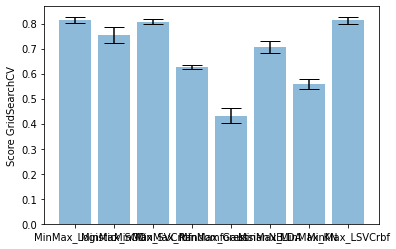

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_Randomforest', 'MinMax_GaussianNB', 'MinMax_LDA', 'MinMax_KN', 'MinMax_LSVCrbf']
[[0.8135175  0.75362185 0.80799263 0.62709024 0.43176182 0.70807858
  0.55822591 0.81354205]
 [0.01176292 0.03200151 0.00826835 0.00844148 0.029529   0.02424258
  0.02058615 0.01339752]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,8))

Evaluando modelo MinMax_Logistic (1/8)


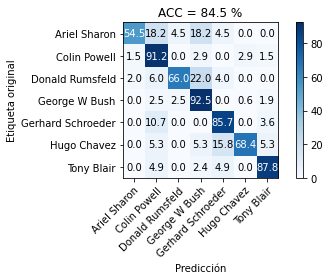

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.55      0.67        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.87      0.66      0.75        50
    George W Bush       0.89      0.92      0.90       159
Gerhard Schroeder       0.75      0.86      0.80        28
      Hugo Chavez       0.81      0.68      0.74        19
       Tony Blair       0.86      0.88      0.87        41

         accuracy                           0.84       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.84      0.84       387

Evaluando modelo MinMax_SGD (2/8)


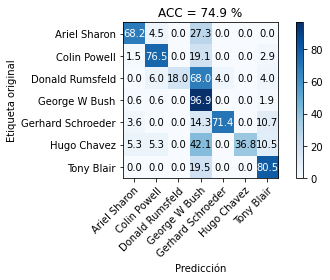

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.68      0.73        22
     Colin Powell       0.90      0.76      0.83        68
  Donald Rumsfeld       1.00      0.18      0.31        50
    George W Bush       0.68      0.97      0.80       159
Gerhard Schroeder       0.91      0.71      0.80        28
      Hugo Chavez       1.00      0.37      0.54        19
       Tony Blair       0.73      0.80      0.77        41

         accuracy                           0.75       387
        macro avg       0.86      0.64      0.68       387
     weighted avg       0.80      0.75      0.72       387

Evaluando modelo MinMax_SVCrbf (3/8)


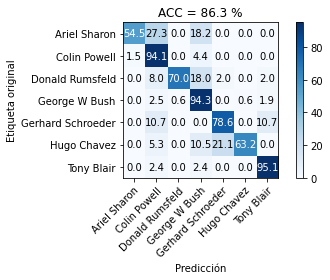

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.55      0.69        22
     Colin Powell       0.77      0.94      0.85        68
  Donald Rumsfeld       0.97      0.70      0.81        50
    George W Bush       0.89      0.94      0.91       159
Gerhard Schroeder       0.81      0.79      0.80        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.85      0.95      0.90        41

         accuracy                           0.86       387
        macro avg       0.88      0.79      0.82       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_Randomforest (4/8)


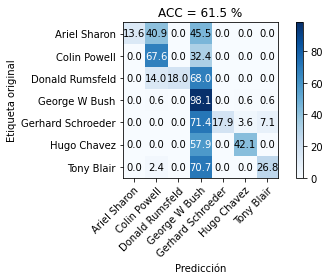

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.14      0.24        22
     Colin Powell       0.72      0.68      0.70        68
  Donald Rumsfeld       1.00      0.18      0.31        50
    George W Bush       0.55      0.98      0.71       159
Gerhard Schroeder       1.00      0.18      0.30        28
      Hugo Chavez       0.80      0.42      0.55        19
       Tony Blair       0.79      0.27      0.40        41

         accuracy                           0.61       387
        macro avg       0.84      0.41      0.46       387
     weighted avg       0.73      0.61      0.56       387

Evaluando modelo MinMax_GaussianNB (5/8)


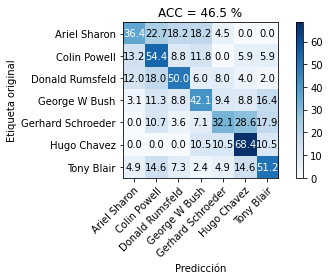

                   precision    recall  f1-score   support

     Ariel Sharon       0.27      0.36      0.31        22
     Colin Powell       0.47      0.54      0.51        68
  Donald Rumsfeld       0.47      0.50      0.49        50
    George W Bush       0.77      0.42      0.54       159
Gerhard Schroeder       0.27      0.32      0.30        28
      Hugo Chavez       0.28      0.68      0.39        19
       Tony Blair       0.36      0.51      0.42        41

         accuracy                           0.47       387
        macro avg       0.41      0.48      0.42       387
     weighted avg       0.55      0.47      0.48       387

Evaluando modelo MinMax_LDA (6/8)


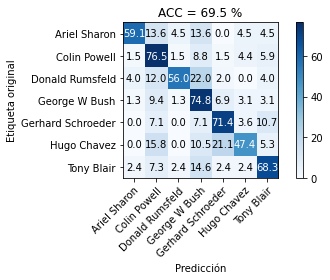

                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.59      0.63        22
     Colin Powell       0.62      0.76      0.68        68
  Donald Rumsfeld       0.85      0.56      0.67        50
    George W Bush       0.80      0.75      0.77       159
Gerhard Schroeder       0.53      0.71      0.61        28
      Hugo Chavez       0.45      0.47      0.46        19
       Tony Blair       0.64      0.68      0.66        41

         accuracy                           0.70       387
        macro avg       0.65      0.65      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo MinMax_KN (7/8)


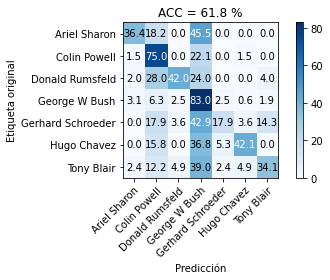

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.36      0.42        22
     Colin Powell       0.55      0.75      0.64        68
  Donald Rumsfeld       0.75      0.42      0.54        50
    George W Bush       0.65      0.83      0.73       159
Gerhard Schroeder       0.45      0.18      0.26        28
      Hugo Chavez       0.62      0.42      0.50        19
       Tony Blair       0.61      0.34      0.44        41

         accuracy                           0.62       387
        macro avg       0.59      0.47      0.50       387
     weighted avg       0.62      0.62      0.59       387

Evaluando modelo MinMax_LSVCrbf (8/8)


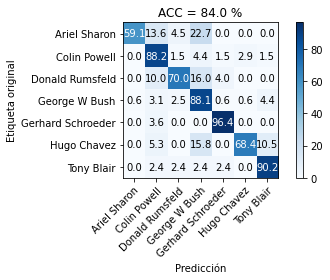

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.79      0.88      0.83        68
  Donald Rumsfeld       0.83      0.70      0.76        50
    George W Bush       0.88      0.88      0.88       159
Gerhard Schroeder       0.84      0.96      0.90        28
      Hugo Chavez       0.81      0.68      0.74        19
       Tony Blair       0.79      0.90      0.84        41

         accuracy                           0.84       387
        macro avg       0.84      0.80      0.81       387
     weighted avg       0.84      0.84      0.84       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)
